In [4]:
from dms2dec.dms_convert import dms2dec
import numpy as np

lat = dms2dec('''44°25′34″N''') # converts to dec
lon = dms2dec('''8°53′19″E''') # converts to dec
print("Center Lat :{}, Lon:{}".format(lat, lon))

def ToEastPosition(lon, lat , dist):
    r_earth = 6378
    return lon + (dist / r_earth) * (180 / np.pi) / np.cos(lat * np.pi / 180), lat
def ToNorthPosition(lon, lat , dist):
    r_earth = 6378
    return lon, lat+ (dist / r_earth) * (180 / np.pi) / np.cos(lon * np.pi / 180)
lon_i , lat_i = ToNorthPosition(lon, lat, 1)
lon_upleft, lat_upleft = ToEastPosition(lon_i, lat_i, -1)
lon_i , lat_i = ToNorthPosition(lon, lat, -1)
lon_downright, lat_downright = ToEastPosition(lon_i, lat_i,1)

print("Left Up Lat :{}, Lon:{}".format(lat_upleft, lon_upleft))
print("Right Down Lat :{}, Lon:{}".format(lat_downright, lon_downright))

Center Lat :44.42611111111111, Lon:8.88861111111111
Left Up Lat :44.43520365289531, Lon:8.876030145953349
Right Down Lat :44.41701856932691, Lon:8.901188163010731


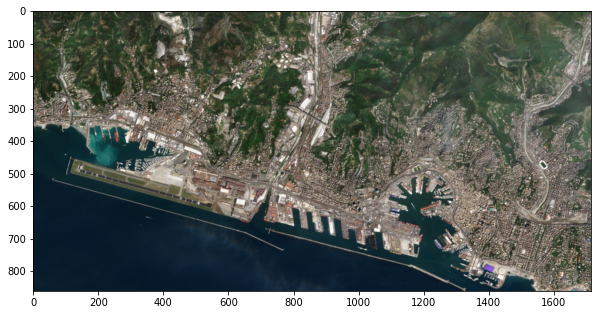

In [5]:
import glob
import rasterio
from rio_color import operations
from matplotlib import pyplot as plt
from rasterio import plot

def preprocess(img):
    ops = "sigmoidal rgb 10 0.05"
    img = rasterio.plot.adjust_band(img)
    maxi = np.max(img)
    mini = np.min(img)
    assert img.shape[0] == 3
    assert img.min() >= 0
    assert img.max() <= 1
    for func in operations.parse_operations(ops):
        img = func(img)
    smax = 255
    smin = 0
    img = ( img - mini ) * (smax - smin) / ( maxi - mini ) + smin
    return img

outtif = './result/result_true_color.tiff'
file_list = []
rgb_index = [4, 3, 2]

for i in rgb_index:
    for img in glob.glob('./dataset/*.tiff'):
        if img.endswith('B0{}_(Raw).tiff'.format(i)):
            file_list.append(img)

rgb = []
for k, i in enumerate(file_list):
    with rasterio.open(i) as img:
        rgb.append(img.read(1))
        if k == 0:
            meta = img.meta
rgb = np.stack([rgb[0], rgb[1], rgb[2]])
rgb = preprocess(rgb)

rgb_plot = rasterio.plot.adjust_band(rgb)

plt.figure(figsize=(10, 10))
rasterio.plot.show(rgb_plot)

meta.update(count = len(file_list), dtype = rasterio.uint8)
with rasterio.open(outtif,'w', ** meta) as dst:
    dst.write(rgb)
    dst.close()

In [7]:
from osgeo import gdal, osr
import math

gdal.UseExceptions()

ds = gdal.Open(outtif)
gt = ds.GetGeoTransform()  # Geotransforms allow conversion of pixel to map coordinates
crs = ds.GetProjection()     
ds = None

def convert(lon, lat):
    # Reproject lon/lat to CRS of raster
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)  # WGS84 4326

    target = osr.SpatialReference()
    target.ImportFromWkt(crs)
    transform = osr.CoordinateTransformation(source, target)

    mx, my, z = transform.TransformPoint(lat, lon)
    return mx, my

x_upleft, y_upleft = convert(lon_upleft,lat_upleft)
x_downright, y_downright = convert(lon_downright,lat_downright)
window = (x_upleft, y_upleft, x_downright, y_downright)
cropped_img = gdal.Translate('./result/crop.tif', outtif, projWin = window)
cropped_img = None